In [1]:
import pandas as pd
import numpy as np
from math import sqrt, ceil
from timeit import timeit, Timer

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

## Load data

In [4]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [5]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
all_years = range(2005, 2019)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [6]:
all_season_scores = male_scores.loc[male_scores['event']!='WR']
all_world_scores = male_scores.loc[male_scores['event']=='WR']

# Check arbitrariness of multi-factor

In [7]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)

In [8]:
def calculate_score_contribution(season_scores, baseline, event_scores, skater_scores, verbose=False):
    '''
    Calculate the average proportion (between 0 and 1) of each factor and the baseline in the season score
    '''
    result_df = season_scores.copy()
    n_factor = skater_scores.shape[1]
    for i in range(n_factor):
        predicted_scores = (event_scores.iloc[:, [i]] @ skater_scores.iloc[:, [i]].T).unstack().reset_index()
        predicted_scores.columns = ['name', 'event', f'score_{i}']
        result_df = pd.merge(result_df, predicted_scores, on=['name', 'event'])

    result_df['baseline'] = baseline

    result_df['predicted_score'] = 0
    for i in range(n_factor):
        result_df['predicted_score'] += result_df[f'score_{i}']
    result_df['predicted_score'] += baseline
    
    contributions = []
    for i in range(n_factor):
        contribution = result_df[f'score_{i}'].sum() / result_df['predicted_score'].sum()
        contributions.append(contribution)
        if verbose:
            print(f"Factor {i}: {result_df[f'score_{i}'].mean():.2f}, {contribution:.5f}")
    
    baseline_contribution = baseline / result_df['predicted_score'].mean()
    if verbose:
        print(f'Baseline: {baseline:.2f}, {baseline_contribution:.5f}')
        print(f"Avg predicted score: {result_df['predicted_score'].mean():.2f}")
    contributions.append(baseline_contribution)
    
    return contributions

In [9]:
def plot_2_factor(seeds, skater_scores_list, world_ranking, contributions_list, filename=None):
    '''
    Plot rank heatmap and pie chart of score contribution for different skater scores
    '''
    winter_cmap = mpl.cm.get_cmap('winter')
    fig = plt.figure(figsize=(7, 10))
    grid = plt.GridSpec(10, len(seeds))
    
    for i, (seed, skater_scores, contributions) in enumerate(zip(seeds, skater_scores_list, contributions_list)):
        skater_scores = skater_scores.reindex(world_scores.index).dropna()        
        n_skaters = skater_scores.shape[0]
        n_factors = skater_scores.shape[1]        
        result_ranks = skater_scores.values.argsort(axis=0).argsort(axis=0) 
        
        ax = fig.add_subplot(grid[:-1, i])
        ax.imshow(result_ranks, cmap='winter_r')
        ax.grid(None)

        for j in range(n_factors):
            ax.axvline(j-0.5, lw=2, color='w')    

        ax.set_xticks([0, 1])
        ax.set_xticklabels([1, 2])
        ax.set_title(seed)
        ax.set_ylim(bottom=23.5)
        ax.set_yticks(range(24))
        ax.set_facecolor('w')
        
        if i==0:
            pass
            ax.set_yticklabels(world_ranking)
            [t.set_color(winter_cmap(z/24)) for z, t in enumerate(ax.yaxis.get_ticklabels())]
        else:
            ax.set_yticks([])

        for j in range(n_skaters):
            for k in range(n_factors):
                ax.text(k, j, f'{skater_scores.iloc[j, k]:.1f}', ha='center', va='center', color='w', fontsize=12)

        ax.set_xlabel(' ', fontsize=15)
        axp = fig.add_subplot(grid[-1:, i])
        axp.set_aspect('equal')
        
        labels = [f'Factor {n+1}' for n in range(n_factors)] + ['Baseline']
        axp.pie(contributions, radius=2, labeldistance=1.3, startangle=90+contributions[0]*360, colors=['tab:red', 'tab:orange', 'tab:brown'], counterclock=False, labels=labels)

    fig.suptitle('Seed', x=0.56, y=1.01, fontsize=15)
    plt.tight_layout()
    
    if filename:
        fig.savefig(f'viz/{filename}.png', bbox_inches='tight')

Alpha: 0.0005, Iter: 999, Last RMSE: 3.26, Delta RMSE: 1.7917722514
Factor 0: 55.72, 0.33737
Factor 1: 45.15, 0.27338
Baseline: 64.29, 0.38926
Avg predicted score: 165.17
Alpha: 0.0005, Iter: 999, Last RMSE: 3.4, Delta RMSE: 1.8709280853
Factor 0: 42.97, 0.26018
Factor 1: 59.59, 0.36077
Baseline: 62.61, 0.37904
Avg predicted score: 165.17


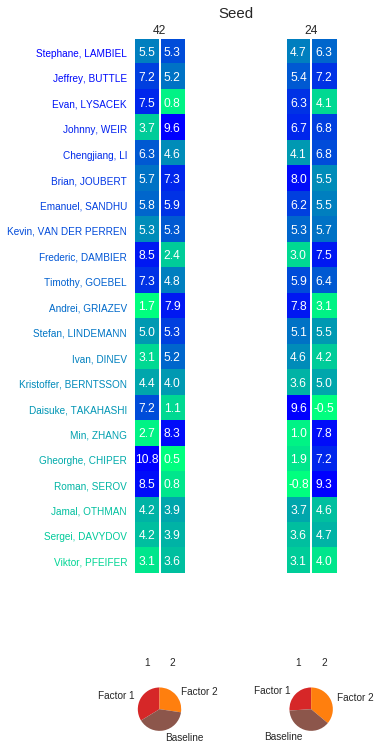

In [10]:
year = 2005
n_factors = 2
seeds = [42, 24]
skater_scores_list = []
contributions_list = []
season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
avg_scores = season_scores.groupby('name')['score'].mean()
_, world_ranking = return_ranking(avg_scores, world_scores)


for seed in seeds:
    baseline, event_scores, skater_scores = train_multi(season_scores, alpha=0.0005, n_iter=1000, n_factors=n_factors, init_seed=seed)
    contributions = calculate_score_contribution(season_scores, baseline, event_scores, skater_scores, verbose=True)
    
    skater_scores_list.append(skater_scores)
    contributions_list.append(contributions)
    
plot_2_factor(seeds, skater_scores_list, world_ranking, contributions_list, f'2_factor_simul_{year}.png')

Alpha: 0.0005, Iter: 999, Last RMSE: 4.44, Delta RMSE: 2.3785701675
Alpha: 0.0005, Iter: 999, Last RMSE: 3.81, Delta RMSE: 2.0423864459


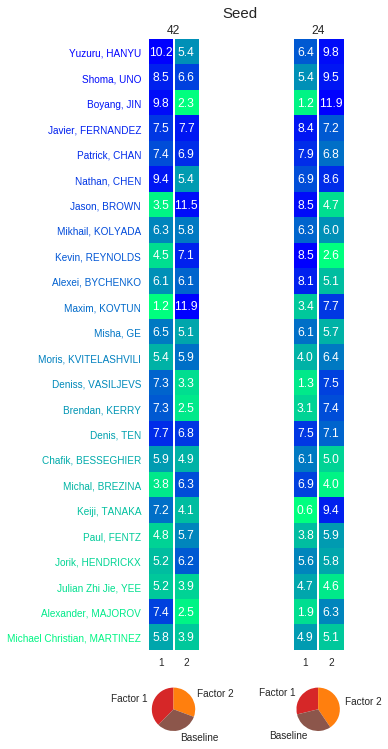

In [11]:
year = 2017
n_factors = 2
seeds = [42, 24]
skater_scores_list = []
contributions_list = []
season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
avg_scores = season_scores.groupby('name')['score'].mean()
_, world_ranking = return_ranking(avg_scores, world_scores)


for seed in seeds:
    baseline, event_scores, skater_scores = train_multi(season_scores, alpha=0.0005, n_iter=1000, n_factors=n_factors, init_seed=seed)
    contributions = calculate_score_contribution(season_scores, baseline, event_scores, skater_scores)
    
    skater_scores_list.append(skater_scores)
    contributions_list.append(contributions)
    
plot_2_factor(seeds, skater_scores_list, world_ranking, contributions_list, f'2_factor_simul_{year}.png')

# Sequential multi-factor model

## Toy example

In [12]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
sample_season_scores = season_scores.loc[[1758, 1760, 1765, 1769, 1771, 1776, 1787]]

In [13]:
# Transform long score table to pivot form
season_pivot = pd.pivot_table(sample_season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')

# Convert pivot table to numpy array
true_scores = season_pivot.values

# Store skater and event names to retrieve later
skater_names = list(season_pivot.index)
event_names = list(season_pivot.columns)

# Create lists to store scores of individual factor
multi_skater_scores = []
multi_event_scores = []
multi_baselines = []

# Run gradient descent algorithm
alpha = 0.0005
n_factors = 2
init_seed = 42

for n in range(n_factors):
    # 1. Initialize baseline, event, and skater scores
    print(init_seed+n)
    random_state = np.random.RandomState(seed=init_seed+n)
    baseline = random_state.random_sample()
    skater_scores = random_state.random_sample((len(skater_names), 1))
    event_scores = random_state.random_sample((1, len(event_names)))
    
    # Run gradient descent
    for i in range(1000):
        # 2a. Calculate gradients
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores

        baseline_gradient = np.nansum(residuals)
        event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True)
        skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True)

        ### 2b. Update latent scores using gradients
        baseline = baseline - alpha * baseline_gradient
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients
    
    # Store result for each factor 
    multi_skater_scores.append(skater_scores.ravel())
    multi_event_scores.append(event_scores.ravel())
    multi_baselines.append(baseline)
    
    # Reset true score matrix as negative residual
    final_residuals = skater_scores @ event_scores + baseline - true_scores    
    true_scores = -final_residuals
    pd.DataFrame(true_scores).to_csv(f'viz/true_scores_{n}.csv')

# Create latent score matrices with previously-stored name
multi_skater_scores = pd.DataFrame(multi_skater_scores).T
multi_skater_scores.index = skater_names
multi_skater_scores.to_csv('viz/multi_skater_scores.csv')

multi_event_scores = pd.DataFrame(multi_event_scores).T
multi_event_scores.index = event_names
multi_event_scores.to_csv('viz/multi_event_scores.csv')

42
43


In [14]:
multi_skater_scores

,0,1
"Alexander, MAJOROV",10.678634,0.553675
"Javier, FERNANDEZ",16.701678,0.063863
"Misha, GE",13.587320,2.357501
"Takahito, MURA",14.101404,-2.170872


In [66]:
def train_sequential_multi_log(season_scores, n_factors, skater_order=None, init_seed=42,
             alpha=0.0005, n_iter=1000, verbose=True, additional_iter=[]):
    '''
    Run gradient descent on some season scores table (long format)
    Return skater and event scores (along with final RMSE and other intermediate values if needed)'''

    season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    
    if skater_order is not None:
        season_pivot = season_pivot.loc[skater_order]
        
    skater_names = list(season_pivot.index)
    event_names = list(season_pivot.columns)
    true_scores = season_pivot.values
    
    # Create lists to store scores of individual factor
    multi_skater_scores = []
    multi_event_scores = []
    multi_baselines = []
    all_residuals = []
    
    for n in range(n_factors):
        random_state = np.random.RandomState(init_seed+n)
        skater_scores = random_state.random_sample((len(skater_names), 1))
        event_scores = random_state.random_sample((1, len(event_names)))
        baseline = random_state.random_sample()
        
        for i in range(n_iter):
            # Calculate predicted scores and residuals
            predicted_scores = skater_scores @ event_scores + baseline
            residuals = predicted_scores - true_scores
            
            # Calculate parameter gradients
            skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True)
            event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True)
            baseline_gradient = np.nansum(residuals)

            # Update parameters
            event_scores = event_scores - alpha * event_gradients
            skater_scores = skater_scores - alpha * skater_gradients
            baseline = baseline - alpha * baseline_gradient            
        
            # Print difference in RMSE for last two iterations
            if verbose and i == (n_iter-1):
                rmse_old = np.sqrt(np.nanmean(residuals**2))
                residuals = skater_scores @ event_scores + baseline - true_scores
                rmse_new = np.sqrt(np.nanmean(residuals**2))
                print(f'Factor: {n}, Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 3)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
        
        # Store the latent scores for each factor
        multi_skater_scores.append(skater_scores.ravel())
        multi_event_scores.append(event_scores.ravel())
        multi_baselines.append(baseline)
        
        # Calculate final residual before handing its negative to train the next factor
        final_residuals = skater_scores @ event_scores + baseline - true_scores
        true_scores = -final_residuals
        
        rmse = np.sqrt(np.nanmean(final_residuals**2))
        yield n, true_scores, event_names, skater_names, multi_baselines, multi_event_scores, multi_skater_scores, rmse

In [67]:
def train_sequential_multi(season_scores, **kwargs):
    '''
    Run gradient descent on some season scores table (long format)
    Return latent scores at the end of algorithms
    '''
    log_values = None
    for log_values in train_sequential_multi_log(season_scores, **kwargs):
        pass
    
    event_names = log_values[2]
    skater_names = log_values[3]
    multi_baselines = log_values[4]
    multi_event_scores = log_values[5]
    multi_skater_scores = log_values[6]
    
    # Transform all latent scores into matrices
    multi_skater_scores = pd.DataFrame(multi_skater_scores).T
    multi_skater_scores.index = skater_names
    
    multi_event_scores = pd.DataFrame(multi_event_scores).T
    multi_event_scores.index = event_names
    
    return multi_baselines, multi_event_scores, multi_skater_scores    

Try for 2017 male skaters

In [17]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
world_ranking = list(world_scores.sort_values(ascending=False).index)
baselines, event_scores, skater_scores = train_sequential_multi(season_scores, n_factors=2, alpha=0.0005, n_iter=1000)

Factor: 0, Alpha: 0.0005, Iter: 1000, Last RMSE: 8.859, Delta RMSE: -1.74e-08
Factor: 1, Alpha: 0.0005, Iter: 1000, Last RMSE: 5.805, Delta RMSE: -0.0001042142


Double check final RMSE

In [18]:
season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
np.sqrt(np.nanmean((skater_scores.values @ event_scores.values.T + np.sum(baselines) - season_pivot)**2))

5.805289532915499

## Effect for 2-factor example

Plot the same 2-factor plots for the previous example years (2005 and 2017) and seeds (42 and 24)

Factor: 0, Alpha: 0.0005, Iter: 100, Last RMSE: 8.625, Delta RMSE: -1.7543e-06
Factor: 1, Alpha: 0.0005, Iter: 100, Last RMSE: 7.873, Delta RMSE: -0.0225468177
Factor 0: 94.17, 0.57020
Factor 1: 0.13, 0.00078
Baseline: 70.85, 0.42902
Avg predicted score: 165.16
Factor: 0, Alpha: 0.0005, Iter: 100, Last RMSE: 8.623, Delta RMSE: -2.0525e-06
Factor: 1, Alpha: 0.0005, Iter: 100, Last RMSE: 8.548, Delta RMSE: -0.0021735136
Factor 0: 96.36, 0.58338
Factor 1: 0.17, 0.00104
Baseline: 68.64, 0.41558
Avg predicted score: 165.17


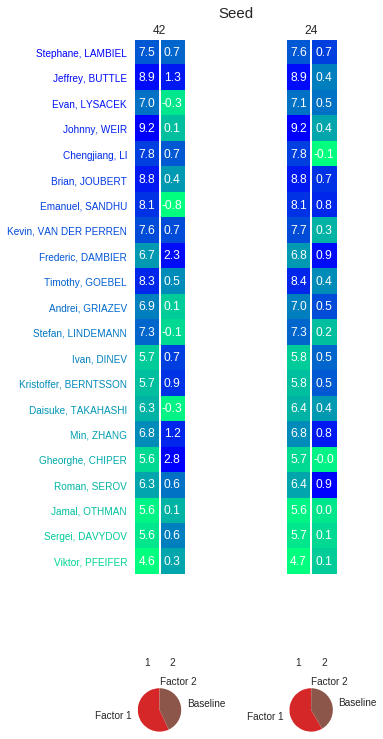

In [19]:
year = 2005
n_factors = 2
seeds = [42, 24]
skater_scores_list = []
contributions_list = []
season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
avg_scores = season_scores.groupby('name')['score'].mean()
_, world_ranking = return_ranking(avg_scores, world_scores)


for seed in seeds:
    baselines, event_scores, skater_scores = train_sequential_multi(season_scores, alpha=0.0005, n_iter=100, n_factors=n_factors, init_seed=seed)
    contributions = calculate_score_contribution(season_scores, np.sum(baselines), event_scores, skater_scores, verbose=True)
    
    skater_scores_list.append(skater_scores)
    contributions_list.append(contributions)
    
plot_2_factor(seeds, skater_scores_list, world_ranking, contributions_list, f'2_factor_seq_{year}.png')

Factor: 0, Alpha: 0.0005, Iter: 100, Last RMSE: 8.859, Delta RMSE: -2.073e-07
Factor: 1, Alpha: 0.0005, Iter: 100, Last RMSE: 8.782, Delta RMSE: -0.0025331584
Factor 0: 149.63, 0.65373
Factor 1: 0.13, 0.00059
Baseline: 79.12, 0.34568
Avg predicted score: 228.89
Factor: 0, Alpha: 0.0005, Iter: 100, Last RMSE: 8.859, Delta RMSE: -1.859e-07
Factor: 1, Alpha: 0.0005, Iter: 100, Last RMSE: 8.186, Delta RMSE: -0.0234028276
Factor 0: 150.75, 0.65856
Factor 1: 0.25, 0.00110
Baseline: 77.90, 0.34033
Avg predicted score: 228.90


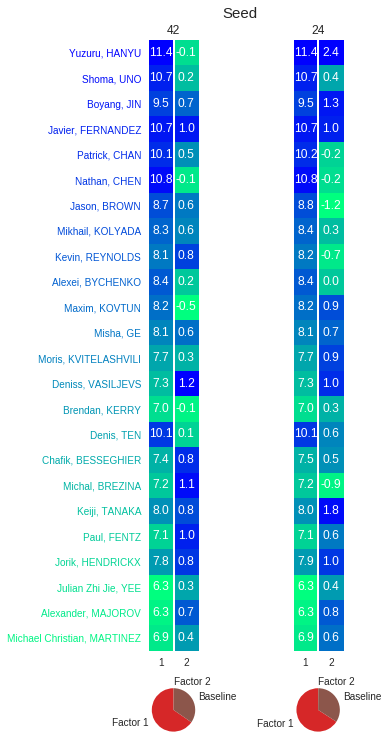

In [20]:
year = 2017
n_factors = 2
seeds = [42, 24]
skater_scores_list = []
contributions_list = []
season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
avg_scores = season_scores.groupby('name')['score'].mean()
_, world_ranking = return_ranking(avg_scores, world_scores)


for seed in seeds:
    baselines, event_scores, skater_scores = train_sequential_multi(season_scores, alpha=0.0005, n_iter=100, n_factors=n_factors, init_seed=seed)
    contributions = calculate_score_contribution(season_scores, np.sum(baselines), event_scores, skater_scores, verbose=True)
    
    skater_scores_list.append(skater_scores)
    contributions_list.append(contributions)
    
plot_2_factor(seeds, skater_scores_list, world_ranking, contributions_list, f'2_factor_seq_{year}.png')

## Effect of seed

In [21]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
world_ranking = list(world_scores.sort_values(ascending=False).index)
season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')

Without changing seed: RMSE does not seem to drop after the first few factors

In [22]:
skater_names = list(season_pivot.index)
event_names = list(season_pivot.columns)
true_scores = season_pivot.values
n_factor = 30
alpha = 0.0005
n_iter = 1000

for factor in range(n_factor):
    random_state = np.random.RandomState(42)
    skater_scores = random_state.random_sample((true_scores.shape[0], 1))
    event_scores = random_state.random_sample((1, true_scores.shape[1]))
    baseline = random_state.random_sample()

    for i in range(n_iter):
        # Calculate predicted scores and residuals
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores

        # Calculate parameter gradients
        skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True)
        event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True)
        baseline_gradient = np.nansum(residuals)

        # Update parameters
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients
        baseline = baseline - alpha * baseline_gradient            


        # Print difference in RMSE for last two iterations
        if i == (n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(rmse_old, rmse_new)
            print(f'Factor: {factor}, Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 3)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
    #                 print(np.nansum(skater_scores @ event_scores))

    true_scores = -residuals

8.859330961850546 8.859330944411616
Factor: 0, Alpha: 0.0005, Iter: 1000, Last RMSE: 8.859, Delta RMSE: -1.74e-08
5.163747558545289 5.1636798702006255
Factor: 1, Alpha: 0.0005, Iter: 1000, Last RMSE: 5.164, Delta RMSE: -6.76883e-05
2.3300473232940964 2.3299410553845057
Factor: 2, Alpha: 0.0005, Iter: 1000, Last RMSE: 2.33, Delta RMSE: -0.0001062679
1.268887819420307 1.2686982573920882
Factor: 3, Alpha: 0.0005, Iter: 1000, Last RMSE: 1.269, Delta RMSE: -0.000189562
0.9261193306241753 0.9257873906721344
Factor: 4, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.926, Delta RMSE: -0.00033194
0.7864196614090362 0.7862386675428313
Factor: 5, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.786, Delta RMSE: -0.0001809939
0.7447001325488942 0.7445295813859706
Factor: 6, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.745, Delta RMSE: -0.0001705512
0.7385653440691252 0.7385081309056151
Factor: 7, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.739, Delta RMSE: -5.72132e-05
0.7426434727006334 0.7426188378425161
Factor: 8, Alpha

Changing seed: RMSE continues to drop

In [23]:
skater_names = list(season_pivot.index)
event_names = list(season_pivot.columns)
true_scores = season_pivot.values
n_factor = 30
alpha = 0.0005
n_iter = 1000

for factor in range(n_factor):
    random_state = np.random.RandomState(42+factor)
    skater_scores = random_state.random_sample((true_scores.shape[0], 1))
    event_scores = random_state.random_sample((1, true_scores.shape[1]))
    baseline = random_state.random_sample()

    for i in range(n_iter):
        # Calculate predicted scores and residuals
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores

        # Calculate parameter gradients
        skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True)
        event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True)
        baseline_gradient = np.nansum(residuals)

        # Update parameters
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients
        baseline = baseline - alpha * baseline_gradient            


        # Print difference in RMSE for last two iterations
        if i == (n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(rmse_old, rmse_new)
            print(f'Factor: {factor}, Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 3)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
    #                 print(np.nansum(skater_scores @ event_scores))

    true_scores = -residuals

8.859330961850546 8.859330944411616
Factor: 0, Alpha: 0.0005, Iter: 1000, Last RMSE: 8.859, Delta RMSE: -1.74e-08
5.8053937470994 5.8052895329155
Factor: 1, Alpha: 0.0005, Iter: 1000, Last RMSE: 5.805, Delta RMSE: -0.0001042142
2.7521162417336558 2.751871190166965
Factor: 2, Alpha: 0.0005, Iter: 1000, Last RMSE: 2.752, Delta RMSE: -0.0002450516
1.2305645457141914 1.230349413021204
Factor: 3, Alpha: 0.0005, Iter: 1000, Last RMSE: 1.23, Delta RMSE: -0.0002151327
0.8005360818874533 0.800373873666347
Factor: 4, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.8, Delta RMSE: -0.0001622082
0.6614323535056265 0.6612623476836447
Factor: 5, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.661, Delta RMSE: -0.0001700058
0.6116974341790589 0.6115888633897472
Factor: 6, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.612, Delta RMSE: -0.0001085708
0.4920523652213367 0.4918850137596573
Factor: 7, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.492, Delta RMSE: -0.0001673515
0.47482029770122547 0.4747975232639247
Factor: 8, Alpha: 0

### Animation

In [24]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
world_ranking = list(world_scores.sort_values(ascending=False).index)
season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
example_skater_order = np.load('viz/example_skater_order.npy')

season_pivot = season_pivot.loc[example_skater_order]        
skater_names = list(season_pivot.index)
event_names = list(season_pivot.columns)
n_skaters = len(skater_names)
n_events = len(event_names)

In [25]:
n_factors = 5
n_iter = 1000
log_every= 100
alpha = 0.0005
init_seed = 42

true_scores = season_pivot.values
skater_names = list(season_pivot.index)
event_names = list(season_pivot.columns)
true_scores = season_pivot.values

multi_skater_scores = np.zeros((n_skaters, n_factors))
multi_event_scores = np.zeros((n_factors, n_events))

all_skater_scores = []
all_event_scores = []
all_baselines = []
all_residuals = []
all_rmses = []
all_iters = []
all_factors = []
all_iters = []
all_cum_iters = []

cum_iter_log = 0
for n in range(n_factors):
    print('factor', n)
    random_state = np.random.RandomState(init_seed+n)
    skater_scores = random_state.random_sample((len(skater_names), 1))
    event_scores = random_state.random_sample((1, len(event_names)))
    baseline = random_state.random_sample()
#     print(skater_scores[:2])
    for i in range(n_iter):
        # Calculate predicted scores and residuals
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores
        
        if i%log_every==0:
            all_residuals.append(residuals)
            all_skater_scores.append(multi_skater_scores.copy())
            all_event_scores.append(multi_event_scores.copy())
            all_baselines.append(baseline)
            all_rmses.append(np.sqrt(np.nanmean(residuals**2)))
            all_iters.append(i)
            all_cum_iters.append(cum_iter_log)
            cum_iter_log += log_every

        # Calculate parameter gradients
        skater_gradients = np.nansum(residuals * event_scores, axis=1, keepdims=True)
        event_gradients = np.nansum(residuals * skater_scores, axis=0, keepdims=True)
        baseline_gradient = np.nansum(residuals)

        # Update parameters
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients
        baseline = baseline - alpha * baseline_gradient            


        # Print difference in RMSE for last two iterations
        if i == (n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(f'Factor: {n}, Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 3)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
       
        multi_skater_scores[:, [n]] = skater_scores
        multi_event_scores[[n], :] = event_scores
        
    # Calculate final residual before handing its negative to train the next factor
    final_residuals = skater_scores @ event_scores + baseline - true_scores
    all_residuals.append(final_residuals)
    true_scores = -final_residuals

factor 0
Factor: 0, Alpha: 0.0005, Iter: 1000, Last RMSE: 8.859, Delta RMSE: -1.76e-08
factor 1
Factor: 1, Alpha: 0.0005, Iter: 1000, Last RMSE: 5.153, Delta RMSE: -2.20864e-05
factor 2
Factor: 2, Alpha: 0.0005, Iter: 1000, Last RMSE: 2.334, Delta RMSE: -0.0002651683
factor 3
Factor: 3, Alpha: 0.0005, Iter: 1000, Last RMSE: 1.124, Delta RMSE: -0.0002839255
factor 4
Factor: 4, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.87, Delta RMSE: -0.0001308736


In [26]:
def update(i, fig, ax, axr, baseline_text, verbose=False):
    if verbose:
        print(i, end=' ')
    
    fig.suptitle(f'Iteration {all_cum_iters[i]}\nα = 0.0005', x=0.3, y=0.95, va='bottom', ha='center', fontsize=20)
    residuals = all_residuals[i]
    ax.imshow(residuals, cmap='coolwarm_r', vmin=-30, vmax=30, aspect='auto')
    
    skater_score_display = pd.DataFrame(all_skater_scores[i]).applymap('{:5.2f}'.format).apply(lambda x: '  '.join(x), axis=1)
    event_score_display = pd.DataFrame(all_event_scores[i]).applymap('{:5.2f}'.format).apply(lambda x: '\n'.join(x), axis=0)
    ax.set_yticklabels(skater_score_display, fontsize=10)
    ax.set_xticklabels(event_score_display, fontsize=10) 
    
    baseline_text.set_text('{0:.2f}'.format(all_baselines[i]))
    
    axr.plot(all_cum_iters[i-1:i+1], all_rmses[i-1:i+1], '.-', color='tab:brown', clip_on=True)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 

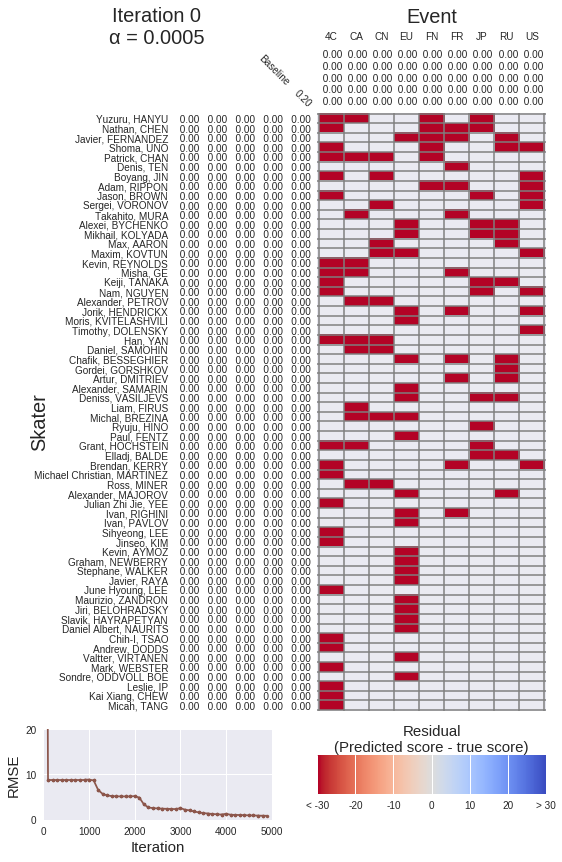

In [27]:
# Set up figure grid
fig = plt.figure(figsize=(9, 13))
grid = plt.GridSpec(20, 2, hspace=1)

# Set up heat map of residuals
ax = fig.add_subplot(grid[:-3, 1])
ax.set_xticks(range(n_events))
ax.set_xticklabels(event_names)
ax.set_xticks(np.arange(n_events+1)-0.5, minor=True)
ax.xaxis.tick_top()
ax.set_xlim(-0.55, n_events-0.45)

ax.set_yticks(range(n_skaters))
ax.set_yticklabels(skater_names)
ax.set_yticks(np.arange(n_skaters+1)-0.5, minor=True)
ax.set_ylim(-0.6, n_skaters-0.45)

ax.grid(which='minor', color='tab:gray', ls='-', lw=1.5)
ax.grid(None, which='major')

baseline_text = ax.text(x=-0.7, y=len(skater_names), s='', rotation=-45, va='bottom', ha='right')

# ax.imshow(all_residuals[(0, 0)], cmap='coolwarm_r', vmin=-30, vmax=30, aspect='auto')

for i, skater in enumerate(skater_names):
    ax.text(x=-6.5, y=i-0.4, s=skater, ha='right')
for i, event in enumerate(event_names):
    ax.text(x=i, y=len(skater_names)+7, s=event, va='bottom', ha='center')
ax.text(x=-1.6, y=len(skater_names)+2.3, s='Baseline', rotation=-45, va='bottom', ha='right')
baseline_text = ax.text(x=-0.7, y=len(skater_names), s='', rotation=-45, va='bottom', ha='right')

ax.text(x=-12, y=len(skater_names)/2, s='Skater', rotation=90, fontsize=20)
ax.text(x=4, y=len(skater_names)+9, s='Event', fontsize=20, ha='center')


axr = fig.add_subplot(grid[-3:, 0])
axr.set_xlim(0, 5000)
axr.set_xticks(range(0, 5001, 1000))
axr.set_xlabel('Iteration', fontsize=15)
axr.set_ylim(0, 20)
axr.set_yticks(np.arange(0, 21, 10))
axr.set_ylabel('RMSE', fontsize=15)


axc = fig.add_subplot(grid[-3:, 1])
cmap = plt.cm.get_cmap('coolwarm')
colors = cmap(np.arange(cmap.N, -1, -1)) # Plot colorbar from red to blue (not blue to red)
axc.imshow([colors], extent=[-30, 30, 0, 10])
axc.xaxis.set_label_position('top') 
axc.set_xlabel('Residual\n(Predicted score - true score)', fontsize=15)
axc.set_xticklabels(['< -30', '-20', '-10', '0', '10', '20', '> 30'])
axc.set_yticks([])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax, axr, baseline_text, verbose=True), 
                     frames=len(all_cum_iters), interval=500)


anim.save('viz/seq_anim_multi.gif', writer='imagemagick')

Visualize skater score for each skater in each event (graph turned out to be way too distracting)

In [28]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
world_ranking = list(world_scores.sort_values(ascending=False).index)

In [29]:
baselines, event_scores, skater_scores = train_sequential_multi(season_scores, n_factors=5, alpha=0.0005, n_iter=1000)

Factor: 0, Alpha: 0.0005, Iter: 1000, Last RMSE: 8.859, Delta RMSE: -1.74e-08
Factor: 1, Alpha: 0.0005, Iter: 1000, Last RMSE: 5.805, Delta RMSE: -0.0001042142
Factor: 2, Alpha: 0.0005, Iter: 1000, Last RMSE: 2.752, Delta RMSE: -0.0002450516
Factor: 3, Alpha: 0.0005, Iter: 1000, Last RMSE: 1.23, Delta RMSE: -0.0002151327
Factor: 4, Alpha: 0.0005, Iter: 1000, Last RMSE: 0.8, Delta RMSE: -0.0001622082


In [30]:
df_compare = season_scores.copy()
print(df_compare.head())

for i in range(5):
    predicted_scores = np.outer(skater_scores.values[:, i], event_scores.values[:, i]) + baselines[i]    
    predicted_scores = pd.DataFrame(predicted_scores, index=skater_scores.index, columns=event_scores.index)

    unstacked_predicted_scores = predicted_scores.unstack().reset_index()
    unstacked_predicted_scores.columns = ['event', 'name', 'score']
    df_compare = pd.merge(df_compare, unstacked_predicted_scores, how='left', on=['event', 'name'], suffixes=['', str(i)])

                 name  year event   score
1743       Shoma, UNO  2017    US  279.34
1744     Jason, BROWN  2017    US  268.38
1745     Adam, RIPPON  2017    US  261.43
1746  Sergei, VORONOV  2017    US  245.28
1747      Boyang, JIN  2017    US  245.08


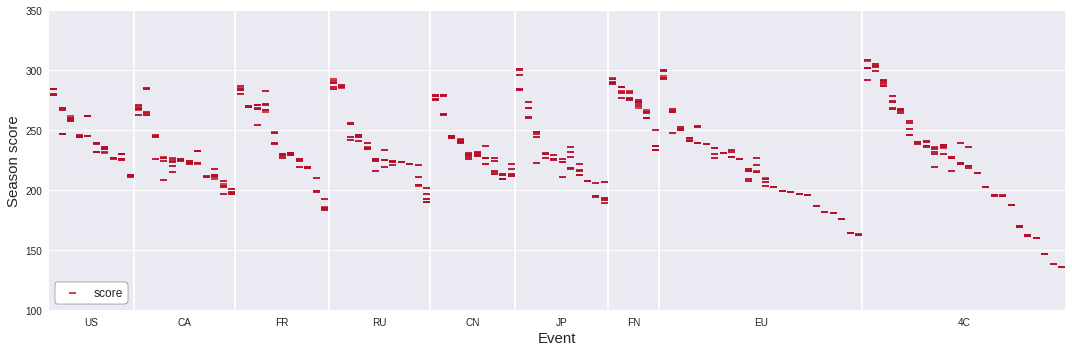

In [31]:
# Function to plot predicted score against true score for any model (with appropriate mega-table)
fig, ax = plt.subplots(figsize=(15, 5))
x_coords = np.arange(len(df_compare))
df_compare_scores = df_compare.loc[:, 'score0':]

ax.scatter(x_coords, df_compare['score'], color='tab:red', marker='_')
cum_scores = pd.Series([0]*len(df_compare), index=df_compare.index)
for i in range(5):
    cum_scores = cum_scores + df_compare_scores.iloc[:, i]
    ax.scatter(x_coords, cum_scores, color=colors[i], marker='_')
ax.grid(axis='x')

# Plot grids that separate events instead
events = df_compare['event'].drop_duplicates()
event_counts = df_compare['event'].value_counts().loc[events]
for count in event_counts.cumsum():
    ax.axvline(count-0.5, color='white', zorder=0)
ax.set_xticks(event_counts.cumsum() - event_counts/2 - 0.5)
ax.set_xticklabels(events)

ax.set_xlim([-0.5, len(x_coords)-0.5])
ax.set_ylim([100, 350])
ax.set_xlabel('Event', fontsize=15)
ax.set_ylabel('Season score', fontsize=15)

ax.legend(loc='lower left', **legend_opts)
plt.tight_layout()
plt.show()

### Changing the number of factors

In [36]:
def cross_val_sequential(n_factor, years1, years2,
                        season_scores_df, world_scores_df, avg_taus,
                        multi_alpha=0.0005, log_alpha=0.0005,
                        multi_n_iter=1001, log_n_iter=1001):
    '''
    For a given number of factor, train the multi-factor & logisitc regression models and return two dictionaries
    The first dictionary contains the train improvement in Kendall's tau for each year
    The second dictionary contains the validation improvement in Kendall's tau for each year
    '''
    X1 = {}
    X2 = {}

    for year in (years1 + years2):
        print(year, end=' ')
        
        # Step 1: train multi-factor model
        season_scores, world_scores = get_yearly_scores(year, season_scores_df, world_scores_df)
        baselines, event_scores, skater_scores = train_sequential_multi(season_scores, n_factors=n_factor, alpha=multi_alpha, n_iter=multi_n_iter, verbose=True)
        
        # Normalize and take pairwise differences
        skater_scores = skater_scores.reindex(world_scores.index).dropna()
        normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
        X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))
        
        # Store difference matrices for each year
        if year in years1:
            X1[year] = X
        else:
            X2[year] = X
    
    # Stack predictor matrices for both folds
    stacked_X1 = np.concatenate(list(X1.values()))
    stacked_X2 = np.concatenate(list(X2.values()))
    
    # Step 2: train logistic regression model for both folds
    print('1st fold')
    beta1 = log_gradient_ascent(stacked_X1, n_iter=log_n_iter, alpha=log_alpha)
    print('2nd fold')
    beta2 = log_gradient_ascent(stacked_X2, n_iter=log_n_iter, alpha=log_alpha)
    
    # Step 3 & 4: evaluate logistic regression model on both folds
    dtaus_train = {}
    dtaus_val = {}
    for year in years1:
        dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
    for year in years2:
        dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]
        
    return dtaus_train, dtaus_val

In [37]:
# Split 10 years into train and validation set
random_state = np.random.RandomState(seed=42)
years1 = list(random_state.choice(train_years, size=5, replace=False))
years2 = [year for year in train_years if year not in years1]
years1, years2

([2016, 2006, 2012, 2005, 2014], [2007, 2009, 2010, 2013, 2017])

In [38]:
# Get yearly Kendall's tau from average model for comparison
avg = AverageScore()
avg_result = avg.evaluate_over_years(all_years, all_season_scores, all_world_scores).set_index('year')
avg_taus = avg_result['tau'].to_dict()

In [39]:
# Collect all train and validation Kendall's tau improvement for each number of factors
n_factors = 2**np.arange(1, 8)
dtaus_train_all = {}
dtaus_val_all = {}

for n_factor in n_factors:
    print(f'{n_factor} factors')
    dtaus_train, dtaus_val = cross_val_sequential(n_factor, years1, years2, all_season_scores, all_world_scores, avg_taus,
                                                 multi_n_iter=1001, log_n_iter=1001)
    dtaus_train_all[n_factor] = dtaus_train
    dtaus_val_all[n_factor] = dtaus_val

2 factors
2016 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 10.98, Delta RMSE: -5.57e-08
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.715, Delta RMSE: -6.4434e-05
2006 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 7.951, Delta RMSE: -7.689e-07
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 5.05, Delta RMSE: -0.0001212448
2012 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 8.306, Delta RMSE: -5.65e-07
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.494, Delta RMSE: -0.000203131
2005 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 8.625, Delta RMSE: -5.04e-07
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.661, Delta RMSE: -0.0001572995
2014 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 8.797, Delta RMSE: -5.59e-08
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 5.957, Delta RMSE: -3.86355e-05
2007 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 7.608, Delta RMSE: -2.9e-09
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.026, Delta RMSE: -0.0003004259
2009 

Factor: 5, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.549, Delta RMSE: -8.67466e-05
Factor: 6, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.52, Delta RMSE: -2.69127e-05
Factor: 7, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.49, Delta RMSE: -3.80256e-05
2007 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 7.608, Delta RMSE: -2.9e-09
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.026, Delta RMSE: -0.0003004259
Factor: 2, Alpha: 0.0005, Iter: 1001, Last RMSE: 2.32, Delta RMSE: -0.000299669
Factor: 3, Alpha: 0.0005, Iter: 1001, Last RMSE: 1.461, Delta RMSE: -8.98627e-05
Factor: 4, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.939, Delta RMSE: -0.0003443507
Factor: 5, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.727, Delta RMSE: -0.0002672351
Factor: 6, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.492, Delta RMSE: -0.0001905474
Factor: 7, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.446, Delta RMSE: -3.08485e-05
2009 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 8.184, Delta RMSE: -1.227e-07
Factor: 1, Alpha: 0.000

Factor: 8, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.622, Delta RMSE: -0.0001108029
Factor: 9, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.6, Delta RMSE: -4.90276e-05
Factor: 10, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.548, Delta RMSE: -6.69375e-05
Factor: 11, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.54, Delta RMSE: -2.09548e-05
Factor: 12, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.528, Delta RMSE: -1.96013e-05
Factor: 13, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.513, Delta RMSE: -1.24399e-05
Factor: 14, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.504, Delta RMSE: -2.53838e-05
Factor: 15, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.487, Delta RMSE: -2.25337e-05
2014 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 8.797, Delta RMSE: -5.59e-08
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 5.957, Delta RMSE: -3.86355e-05
Factor: 2, Alpha: 0.0005, Iter: 1001, Last RMSE: 3.084, Delta RMSE: -0.0001289484
Factor: 3, Alpha: 0.0005, Iter: 1001, Last RMSE: 1.728, Delta RMSE: -0.0002303467
Factor: 4, Alpha: 0.

Factor: 13, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.404, Delta RMSE: -2.02162e-05
Factor: 14, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.383, Delta RMSE: -3.79581e-05
Factor: 15, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.367, Delta RMSE: -1.66208e-05
1st fold
Alpha: 0.0005, Iter: 1000, Last LL: -0.33, Delta LL: 0.0
2nd fold
Alpha: 0.0005, Iter: 1000, Last LL: -0.35, Delta LL: 0.0
32 factors
2016 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 10.98, Delta RMSE: -5.57e-08
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.715, Delta RMSE: -6.4434e-05
Factor: 2, Alpha: 0.0005, Iter: 1001, Last RMSE: 2.089, Delta RMSE: -0.0001798932
Factor: 3, Alpha: 0.0005, Iter: 1001, Last RMSE: 1.277, Delta RMSE: -0.0003636577
Factor: 4, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.954, Delta RMSE: -0.0010830722
Factor: 5, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.665, Delta RMSE: -0.0002033212
Factor: 6, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.619, Delta RMSE: -4.98116e-05
Factor: 7, Alpha: 0.0005, Iter: 1001, L

2005 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 8.625, Delta RMSE: -5.04e-07
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.661, Delta RMSE: -0.0001572995
Factor: 2, Alpha: 0.0005, Iter: 1001, Last RMSE: 2.684, Delta RMSE: -0.000102721
Factor: 3, Alpha: 0.0005, Iter: 1001, Last RMSE: 1.481, Delta RMSE: -0.0001903568
Factor: 4, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.944, Delta RMSE: -0.0002407666
Factor: 5, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.792, Delta RMSE: -6.17825e-05
Factor: 6, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.761, Delta RMSE: -6.47051e-05
Factor: 7, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.714, Delta RMSE: -3.46448e-05
Factor: 8, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.622, Delta RMSE: -0.0001108029
Factor: 9, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.6, Delta RMSE: -4.90276e-05
Factor: 10, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.548, Delta RMSE: -6.69375e-05
Factor: 11, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.54, Delta RMSE: -2.09548e-05
Factor: 12, Alpha: 0.00

Factor: 7, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.503, Delta RMSE: -4.60379e-05
Factor: 8, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.495, Delta RMSE: -1.64129e-05
Factor: 9, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.472, Delta RMSE: -2.19469e-05
Factor: 10, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.459, Delta RMSE: -1.23249e-05
Factor: 11, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.452, Delta RMSE: -1.1984e-05
Factor: 12, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.452, Delta RMSE: -1.34307e-05
Factor: 13, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.433, Delta RMSE: -2.04944e-05
Factor: 14, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.412, Delta RMSE: -3.2422e-05
Factor: 15, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.397, Delta RMSE: -1.47048e-05
Factor: 16, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.394, Delta RMSE: -1.58359e-05
Factor: 17, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.392, Delta RMSE: -1.45115e-05
Factor: 18, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.385, Delta RMSE: -1.80951e-05
Factor: 19, Alpha: 0.

Factor: 12, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.419, Delta RMSE: -1.97582e-05
Factor: 13, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.404, Delta RMSE: -2.02162e-05
Factor: 14, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.383, Delta RMSE: -3.79581e-05
Factor: 15, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.367, Delta RMSE: -1.66208e-05
Factor: 16, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.36, Delta RMSE: -2.19191e-05
Factor: 17, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.341, Delta RMSE: -3.85487e-05
Factor: 18, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.321, Delta RMSE: -3.33093e-05
Factor: 19, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.326, Delta RMSE: -1.2761e-05
Factor: 20, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.317, Delta RMSE: -1.29521e-05
Factor: 21, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.304, Delta RMSE: -2.78421e-05
Factor: 22, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.309, Delta RMSE: -1.34444e-05
Factor: 23, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.3, Delta RMSE: -1.59474e-05
Factor: 24, Alpha: 0

Factor: 15, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.357, Delta RMSE: -1.74459e-05
Factor: 16, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.356, Delta RMSE: -9.4568e-06
Factor: 17, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.345, Delta RMSE: -1.80849e-05
Factor: 18, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.332, Delta RMSE: -1.55479e-05
Factor: 19, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.325, Delta RMSE: -1.89486e-05
Factor: 20, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.322, Delta RMSE: -1.39841e-05
Factor: 21, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.315, Delta RMSE: -2.08226e-05
Factor: 22, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.311, Delta RMSE: -8.9955e-06
Factor: 23, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.308, Delta RMSE: -1.188e-05
Factor: 24, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.305, Delta RMSE: -1.85163e-05
Factor: 25, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.297, Delta RMSE: -1.111e-05
Factor: 26, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.295, Delta RMSE: -1.42326e-05
Factor: 27, Alpha: 0.0

Factor: 54, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.234, Delta RMSE: -2.14856e-05
Factor: 55, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.234, Delta RMSE: -1.1424e-05
Factor: 56, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.216, Delta RMSE: -1.21488e-05
Factor: 57, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.213, Delta RMSE: -1.86055e-05
Factor: 58, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.222, Delta RMSE: -2.40717e-05
Factor: 59, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.223, Delta RMSE: -2.39132e-05
Factor: 60, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.22, Delta RMSE: -2.42032e-05
Factor: 61, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.214, Delta RMSE: -1.80587e-05
Factor: 62, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.222, Delta RMSE: -2.31674e-05
Factor: 63, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.214, Delta RMSE: -2.6865e-05
2005 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 8.625, Delta RMSE: -5.04e-07
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.661, Delta RMSE: -0.0001572995
Factor: 2, Alpha: 

Factor: 28, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.288, Delta RMSE: -2.32857e-05
Factor: 29, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.286, Delta RMSE: -1.88738e-05
Factor: 30, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.274, Delta RMSE: -3.18352e-05
Factor: 31, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.264, Delta RMSE: -1.84468e-05
Factor: 32, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.266, Delta RMSE: -9.8046e-06
Factor: 33, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.263, Delta RMSE: -1.95203e-05
Factor: 34, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.251, Delta RMSE: -1.29849e-05
Factor: 35, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.244, Delta RMSE: -2.37387e-05
Factor: 36, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.247, Delta RMSE: -1.92616e-05
Factor: 37, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.248, Delta RMSE: -1.69165e-05
Factor: 38, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.25, Delta RMSE: -1.85061e-05
Factor: 39, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.25, Delta RMSE: -1.08402e-05
Factor: 40, Alpha: 

Factor: 2, Alpha: 0.0005, Iter: 1001, Last RMSE: 2.174, Delta RMSE: -0.0001089169
Factor: 3, Alpha: 0.0005, Iter: 1001, Last RMSE: 1.393, Delta RMSE: -0.0004170816
Factor: 4, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.771, Delta RMSE: -0.0002807246
Factor: 5, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.637, Delta RMSE: -0.0001832228
Factor: 6, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.557, Delta RMSE: -0.0001150473
Factor: 7, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.503, Delta RMSE: -4.60379e-05
Factor: 8, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.495, Delta RMSE: -1.64129e-05
Factor: 9, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.472, Delta RMSE: -2.19469e-05
Factor: 10, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.459, Delta RMSE: -1.23249e-05
Factor: 11, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.452, Delta RMSE: -1.1984e-05
Factor: 12, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.452, Delta RMSE: -1.34307e-05
Factor: 13, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.433, Delta RMSE: -2.04944e-05
Factor: 14, Alpha: 0

Factor: 39, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.269, Delta RMSE: -9.3735e-06
Factor: 40, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.273, Delta RMSE: -1.38769e-05
Factor: 41, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.266, Delta RMSE: -1.18979e-05
Factor: 42, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.27, Delta RMSE: -2.20458e-05
Factor: 43, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.253, Delta RMSE: -1.69719e-05
Factor: 44, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.252, Delta RMSE: -1.82894e-05
Factor: 45, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.235, Delta RMSE: -8.5432e-06
Factor: 46, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.24, Delta RMSE: -1.33477e-05
Factor: 47, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.247, Delta RMSE: -1.83751e-05
Factor: 48, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.237, Delta RMSE: -2.05689e-05
Factor: 49, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.236, Delta RMSE: -1.87068e-05
Factor: 50, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.233, Delta RMSE: -1.58018e-05
Factor: 51, Alpha: 0

Factor: 12, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.419, Delta RMSE: -1.97582e-05
Factor: 13, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.404, Delta RMSE: -2.02162e-05
Factor: 14, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.383, Delta RMSE: -3.79581e-05
Factor: 15, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.367, Delta RMSE: -1.66208e-05
Factor: 16, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.36, Delta RMSE: -2.19191e-05
Factor: 17, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.341, Delta RMSE: -3.85487e-05
Factor: 18, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.321, Delta RMSE: -3.33093e-05
Factor: 19, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.326, Delta RMSE: -1.2761e-05
Factor: 20, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.317, Delta RMSE: -1.29521e-05
Factor: 21, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.304, Delta RMSE: -2.78421e-05
Factor: 22, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.309, Delta RMSE: -1.34444e-05
Factor: 23, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.3, Delta RMSE: -1.59474e-05
Factor: 24, Alpha: 0

Factor: 47, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.262, Delta RMSE: -2.35834e-05
Factor: 48, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.264, Delta RMSE: -1.0392e-05
Factor: 49, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.261, Delta RMSE: -1.8375e-05
Factor: 50, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.261, Delta RMSE: -1.80437e-05
Factor: 51, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.261, Delta RMSE: -2.04578e-05
Factor: 52, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.26, Delta RMSE: -1.2346e-05
Factor: 53, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.266, Delta RMSE: -2.2499e-05
Factor: 54, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.253, Delta RMSE: -1.89696e-05
Factor: 55, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.257, Delta RMSE: -1.52652e-05
Factor: 56, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.242, Delta RMSE: -1.12129e-05
Factor: 57, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.23, Delta RMSE: -1.55247e-05
Factor: 58, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.225, Delta RMSE: -1.15868e-05
Factor: 59, Alpha: 0.0

Factor: 20, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.322, Delta RMSE: -1.39841e-05
Factor: 21, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.315, Delta RMSE: -2.08226e-05
Factor: 22, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.311, Delta RMSE: -8.9955e-06
Factor: 23, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.308, Delta RMSE: -1.188e-05
Factor: 24, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.305, Delta RMSE: -1.85163e-05
Factor: 25, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.297, Delta RMSE: -1.111e-05
Factor: 26, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.295, Delta RMSE: -1.42326e-05
Factor: 27, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.289, Delta RMSE: -1.51156e-05
Factor: 28, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.296, Delta RMSE: -2.1487e-05
Factor: 29, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.287, Delta RMSE: -1.40325e-05
Factor: 30, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.287, Delta RMSE: -1.22895e-05
Factor: 31, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.286, Delta RMSE: -1.47197e-05
Factor: 32, Alpha: 0.0

Factor: 121, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.186, Delta RMSE: -2.52605e-05
Factor: 122, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.181, Delta RMSE: -3.6632e-05
Factor: 123, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.18, Delta RMSE: -1.31798e-05
Factor: 124, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.172, Delta RMSE: -2.64153e-05
Factor: 125, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.184, Delta RMSE: -2.49385e-05
Factor: 126, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.191, Delta RMSE: -1.89163e-05
Factor: 127, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.202, Delta RMSE: -2.73742e-05
2012 Factor: 0, Alpha: 0.0005, Iter: 1001, Last RMSE: 8.306, Delta RMSE: -5.65e-07
Factor: 1, Alpha: 0.0005, Iter: 1001, Last RMSE: 4.494, Delta RMSE: -0.000203131
Factor: 2, Alpha: 0.0005, Iter: 1001, Last RMSE: 2.18, Delta RMSE: -0.0003391605
Factor: 3, Alpha: 0.0005, Iter: 1001, Last RMSE: 1.468, Delta RMSE: -0.0004243574
Factor: 4, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.826, Delta RMSE: -0.0001539728
Factor: 5, A

Factor: 94, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.181, Delta RMSE: -2.11877e-05
Factor: 95, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.182, Delta RMSE: -2.58522e-05
Factor: 96, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.19, Delta RMSE: -1.68788e-05
Factor: 97, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.198, Delta RMSE: -1.42345e-05
Factor: 98, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.205, Delta RMSE: -2.59368e-05
Factor: 99, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.2, Delta RMSE: -2.58131e-05
Factor: 100, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.204, Delta RMSE: -2.14127e-05
Factor: 101, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.202, Delta RMSE: -1.51119e-05
Factor: 102, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.199, Delta RMSE: -1.16465e-05
Factor: 103, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.197, Delta RMSE: -2.94042e-05
Factor: 104, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.201, Delta RMSE: -3.27412e-05
Factor: 105, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.196, Delta RMSE: -1.95439e-05
Factor: 106, 

Factor: 66, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.205, Delta RMSE: -1.66059e-05
Factor: 67, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.216, Delta RMSE: -2.74671e-05
Factor: 68, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.215, Delta RMSE: -1.73918e-05
Factor: 69, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.209, Delta RMSE: -2.2612e-05
Factor: 70, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.205, Delta RMSE: -8.8823e-06
Factor: 71, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.206, Delta RMSE: -1.97148e-05
Factor: 72, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.205, Delta RMSE: -1.13955e-05
Factor: 73, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.194, Delta RMSE: -2.19016e-05
Factor: 74, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.208, Delta RMSE: -1.80721e-05
Factor: 75, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.211, Delta RMSE: -2.35158e-05
Factor: 76, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.214, Delta RMSE: -2.49234e-05
Factor: 77, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.213, Delta RMSE: -4.6451e-06
Factor: 78, Alpha: 

Factor: 39, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.25, Delta RMSE: -1.08402e-05
Factor: 40, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.256, Delta RMSE: -1.69965e-05
Factor: 41, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.253, Delta RMSE: -1.41553e-05
Factor: 42, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.252, Delta RMSE: -2.32392e-05
Factor: 43, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.243, Delta RMSE: -1.99802e-05
Factor: 44, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.241, Delta RMSE: -2.28617e-05
Factor: 45, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.224, Delta RMSE: -1.21634e-05
Factor: 46, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.232, Delta RMSE: -1.55767e-05
Factor: 47, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.235, Delta RMSE: -2.65752e-05
Factor: 48, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.233, Delta RMSE: -1.81691e-05
Factor: 49, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.23, Delta RMSE: -1.90915e-05
Factor: 50, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.221, Delta RMSE: -2.17141e-05
Factor: 51, Alpha:

Factor: 13, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.346, Delta RMSE: -1.26707e-05
Factor: 14, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.345, Delta RMSE: -2.44947e-05
Factor: 15, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.331, Delta RMSE: -2.20822e-05
Factor: 16, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.315, Delta RMSE: -2.82285e-05
Factor: 17, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.314, Delta RMSE: -2.34226e-05
Factor: 18, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.303, Delta RMSE: -1.89203e-05
Factor: 19, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.304, Delta RMSE: -1.48283e-05
Factor: 20, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.298, Delta RMSE: -1.29358e-05
Factor: 21, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.286, Delta RMSE: -2.23875e-05
Factor: 22, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.286, Delta RMSE: -1.87041e-05
Factor: 23, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.293, Delta RMSE: -1.25826e-05
Factor: 24, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.282, Delta RMSE: -1.56916e-05
Factor: 25, Alph

Factor: 115, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.187, Delta RMSE: -1.24857e-05
Factor: 116, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.183, Delta RMSE: -1.90621e-05
Factor: 117, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.186, Delta RMSE: -2.85538e-05
Factor: 118, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.191, Delta RMSE: -2.47394e-05
Factor: 119, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.198, Delta RMSE: -1.94221e-05
Factor: 120, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.189, Delta RMSE: -3.92497e-05
Factor: 121, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.192, Delta RMSE: -2.41252e-05
Factor: 122, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.185, Delta RMSE: -2.71426e-05
Factor: 123, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.178, Delta RMSE: -1.11379e-05
Factor: 124, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.167, Delta RMSE: -3.37262e-05
Factor: 125, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.189, Delta RMSE: -4.05766e-05
Factor: 126, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.189, Delta RMSE: -1.88085e-05
Fact

Factor: 90, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.188, Delta RMSE: -1.45775e-05
Factor: 91, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.183, Delta RMSE: -1.54192e-05
Factor: 92, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.176, Delta RMSE: -1.78407e-05
Factor: 93, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.173, Delta RMSE: -3.18616e-05
Factor: 94, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.178, Delta RMSE: -2.22747e-05
Factor: 95, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.183, Delta RMSE: -2.10603e-05
Factor: 96, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.19, Delta RMSE: -1.48777e-05
Factor: 97, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.194, Delta RMSE: -1.92889e-05
Factor: 98, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.204, Delta RMSE: -2.22111e-05
Factor: 99, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.193, Delta RMSE: -2.30609e-05
Factor: 100, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.191, Delta RMSE: -1.8654e-05
Factor: 101, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.192, Delta RMSE: -1.70865e-05
Factor: 102, Alp

Factor: 62, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.202, Delta RMSE: -2.77384e-05
Factor: 63, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.202, Delta RMSE: -1.99541e-05
Factor: 64, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.199, Delta RMSE: -1.06796e-05
Factor: 65, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.2, Delta RMSE: -6.2041e-06
Factor: 66, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.197, Delta RMSE: -1.44448e-05
Factor: 67, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.207, Delta RMSE: -2.31052e-05
Factor: 68, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.207, Delta RMSE: -1.36376e-05
Factor: 69, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.197, Delta RMSE: -1.24978e-05
Factor: 70, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.195, Delta RMSE: -5.3884e-06
Factor: 71, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.202, Delta RMSE: -1.55435e-05
Factor: 72, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.204, Delta RMSE: -1.70265e-05
Factor: 73, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.193, Delta RMSE: -1.99794e-05
Factor: 74, Alpha: 0

Factor: 36, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.255, Delta RMSE: -2.41321e-05
Factor: 37, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.26, Delta RMSE: -2.31598e-05
Factor: 38, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.246, Delta RMSE: -3.29126e-05
Factor: 39, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.249, Delta RMSE: -1.08348e-05
Factor: 40, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.249, Delta RMSE: -1.53687e-05
Factor: 41, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.252, Delta RMSE: -1.97438e-05
Factor: 42, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.253, Delta RMSE: -2.14314e-05
Factor: 43, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.245, Delta RMSE: -2.80169e-05
Factor: 44, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.243, Delta RMSE: -2.29194e-05
Factor: 45, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.225, Delta RMSE: -7.2825e-06
Factor: 46, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.236, Delta RMSE: -1.81209e-05
Factor: 47, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.247, Delta RMSE: -2.42522e-05
Factor: 48, Alpha:

Factor: 9, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.469, Delta RMSE: -1.38855e-05
Factor: 10, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.449, Delta RMSE: -2.31112e-05
Factor: 11, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.433, Delta RMSE: -1.67555e-05
Factor: 12, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.419, Delta RMSE: -1.97582e-05
Factor: 13, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.404, Delta RMSE: -2.02162e-05
Factor: 14, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.383, Delta RMSE: -3.79581e-05
Factor: 15, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.367, Delta RMSE: -1.66208e-05
Factor: 16, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.36, Delta RMSE: -2.19191e-05
Factor: 17, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.341, Delta RMSE: -3.85487e-05
Factor: 18, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.321, Delta RMSE: -3.33093e-05
Factor: 19, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.326, Delta RMSE: -1.2761e-05
Factor: 20, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.317, Delta RMSE: -1.29521e-05
Factor: 21, Alpha: 

Factor: 111, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.201, Delta RMSE: -1.99894e-05
Factor: 112, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.196, Delta RMSE: -2.07504e-05
Factor: 113, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.195, Delta RMSE: -1.05693e-05
Factor: 114, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.197, Delta RMSE: -2.14716e-05
Factor: 115, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.197, Delta RMSE: -1.60024e-05
Factor: 116, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.183, Delta RMSE: -2.37806e-05
Factor: 117, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.186, Delta RMSE: -3.40982e-05
Factor: 118, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.193, Delta RMSE: -2.69986e-05
Factor: 119, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.199, Delta RMSE: -2.27404e-05
Factor: 120, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.191, Delta RMSE: -2.44159e-05
Factor: 121, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.195, Delta RMSE: -1.78064e-05
Factor: 122, Alpha: 0.0005, Iter: 1001, Last RMSE: 0.192, Delta RMSE: -2.83591e-05
Fact

In [40]:
dtaus_train_all = pd.DataFrame(dtaus_train_all)
dtaus_val_all = pd.DataFrame(dtaus_val_all)
dtaus_train_all

,2,4,8,16,32,64,128
2005,0.019048,0.000000,0.028571,0.047619,0.076190,0.200000,0.276190
2006,-0.079051,-0.079051,-0.015810,-0.015810,0.094862,0.086957,0.292490
2007,-0.007246,0.021739,0.007246,0.007246,0.036232,0.152174,0.289855
2009,0.014493,0.007246,0.065217,0.115942,0.101449,0.231884,0.355072
2010,-0.051948,-0.051948,-0.008658,0.008658,0.060606,0.095238,0.233766
2012,-0.015810,-0.023715,-0.031621,0.055336,0.086957,0.166008,0.324111
2013,0.086957,0.055336,0.086957,0.094862,0.039526,0.166008,0.292490
2014,-0.009524,-0.019048,-0.038095,-0.047619,-0.009524,-0.038095,0.114286
2016,-0.007246,0.028986,0.036232,0.007246,0.036232,0.094203,0.217391
2017,0.007246,0.000000,-0.014493,-0.036232,-0.021739,0.036232,0.210145


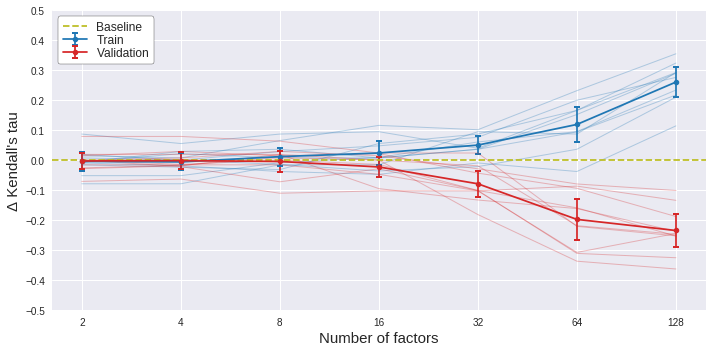

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
ci_multiplier = 2.262/np.sqrt(10)

errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}

# Plot differences in RMSE from baseline for both models
for _, row in dtaus_train_all.iterrows():
    ax.plot(range(len(n_factors)), row, lw=1, color='tab:blue', alpha=0.3, label='_nolegend_')
ax.errorbar(range(len(n_factors)), dtaus_train_all.mean(axis=0), 
             yerr=ci_multiplier*dtaus_train_all.std(axis=0),
           fmt='.-', color='tab:blue', label='Train', **errorbar_opts)

for _, row in dtaus_val_all.iterrows():
    ax.plot(range(len(n_factors)), row, lw=1, color='tab:red', alpha=0.3, label='_nolegend_')
ax.errorbar(range(len(n_factors)), dtaus_val_all.mean(axis=0), 
             yerr=ci_multiplier*dtaus_val_all.std(axis=0),
           fmt='.-', color='tab:red', label='Validation', **errorbar_opts)

ax.axhline(0, ls='--', color='tab:olive', label='Baseline')
ax.legend(**legend_opts)

ax.set_xticks(range(len(n_factors)))
ax.set_xticklabels(n_factors)
ax.set_yticks(np.arange(-0.5, 0.51, 0.1))
ax.set_xlabel('Number of factors', fontsize=15)
ax.set_ylabel("Δ Kendall's tau", fontsize=15)

plt.tight_layout()
fig.savefig('viz/factors_vs_dtau_seq.png')

### Early stopping

In [42]:
n_factors = 2**np.arange(1, 8)
multi_iters = np.arange(0, 101, 20)
log_alpha = 0.0005
n_log_iter = 101
log_log_every = 20

In [68]:
def cross_val_seq_early_stop(n_factors, years1, years2, season_scores_df, world_scores_df, avg_taus,
                            multi_n_iter, log_n_iter,
                            multi_alpha=0.0005, log_alpha=0.0005,
                            log_multi_every=20, log_log_every=20):
    '''
    For a given number of factor, train the multi-factor & logisitc regression models with specified stop iterations
    and return two dictionaries with number of factors as keys
    The first dictionary contains the average train improvement in Kendall's tau for different combinations of stopping iterations
    The first dictionary contains the validation train improvement in Kendall's tau for different combinations of stopping iterations
    '''
    X1 = {}
    X2 = {}

    avg_dtaus_train = {}
    avg_dtaus_val = {}

    for multi_iter in np.arange(0, multi_n_iter, log_multi_every):
        print(f'{n_factors} factors, {multi_iter} iters')
        for year in (years1 + years2):

            # Step 1: train multi-factor model
            season_scores, world_scores = get_yearly_scores(year, season_scores_df, world_scores_df)
            _, _, skater_scores = train_sequential_multi(season_scores, n_factors=n_factors, alpha=multi_alpha, n_iter=multi_iter, verbose=False)

            # Normalize and take pairwise differences
            skater_scores = skater_scores.reindex(world_scores.index).dropna()
            normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
            X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))

            # Store difference matrices for each year
            if year in years1:
                X1[year] = X
            else:
                X2[year] = X

        # Stack predictor matrices for both folds
        stacked_X1 = np.concatenate(list(X1.values()))
        stacked_X2 = np.concatenate(list(X2.values()))

        # Create logistic regression model generators for each fold
        log_gen1 = log_gradient_ascent_log(stacked_X1, alpha=log_alpha, n_iter=log_n_iter, log_every=log_log_every, verbose=False)
        log_gen2 = log_gradient_ascent_log(stacked_X2, alpha=log_alpha, n_iter=log_n_iter, log_every=log_log_every, verbose=False)

        # Train logistic regression model on each fold and return logged values at specified iterations
        for log_log1, log_log2 in zip(log_gen1, log_gen2):
            log_iter = log_log1[0]
            beta1 = log_log1[1]
            beta2 = log_log2[1]

            # Model coefficients at specified iterations are used to evaluate
            # improvement in Kendall's tau on both folds
            dtaus_train = {}
            dtaus_val = {}
            for year in years1:
                dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
                dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
            for year in years2:
                dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
                dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]

            # Take average improvement in Kendall's tau for each combination of
            # stopping iterations of multi-factor and logistic regression model
            avg_dtaus_train[(multi_iter, log_iter)] = np.mean(list(dtaus_train.values()))
            avg_dtaus_val[(multi_iter, log_iter)] = np.mean(list(dtaus_val.values()))
    
    return pd.Series(avg_dtaus_train).unstack(), pd.Series(avg_dtaus_val).unstack()

In [69]:
# Perform 2-fold cross validation for each factors (2,4,8,...,128)
n_factors = 2**np.arange(1, 8)
avg_dtaus_train_all = {}
avg_dtaus_val_all = {}

for n_factor in n_factors:
    print(f'{n_factor} factors')
    avg_dtaus_train, avg_dtaus_val = cross_val_seq_early_stop(n_factor, years1, years2, all_season_scores, all_world_scores, avg_taus,
                                    multi_n_iter=101, log_n_iter=101,
                                    log_multi_every=5, log_log_every=5)
    avg_dtaus_train_all[n_factor] = avg_dtaus_train
    avg_dtaus_val_all[n_factor] = avg_dtaus_val

2 factors
2 factors, 0 iters
2 factors, 5 iters
2 factors, 10 iters
2 factors, 15 iters
2 factors, 20 iters
2 factors, 25 iters
2 factors, 30 iters
2 factors, 35 iters
2 factors, 40 iters
2 factors, 45 iters
2 factors, 50 iters
2 factors, 55 iters
2 factors, 60 iters
2 factors, 65 iters
2 factors, 70 iters
2 factors, 75 iters
2 factors, 80 iters
2 factors, 85 iters
2 factors, 90 iters
2 factors, 95 iters
2 factors, 100 iters
4 factors
4 factors, 0 iters
4 factors, 5 iters
4 factors, 10 iters
4 factors, 15 iters
4 factors, 20 iters
4 factors, 25 iters
4 factors, 30 iters
4 factors, 35 iters
4 factors, 40 iters
4 factors, 45 iters
4 factors, 50 iters
4 factors, 55 iters
4 factors, 60 iters
4 factors, 65 iters
4 factors, 70 iters
4 factors, 75 iters
4 factors, 80 iters
4 factors, 85 iters
4 factors, 90 iters
4 factors, 95 iters
4 factors, 100 iters
8 factors
8 factors, 0 iters
8 factors, 5 iters
8 factors, 10 iters
8 factors, 15 iters
8 factors, 20 iters
8 factors, 25 iters
8 factors, 30 

Plot heatmaps

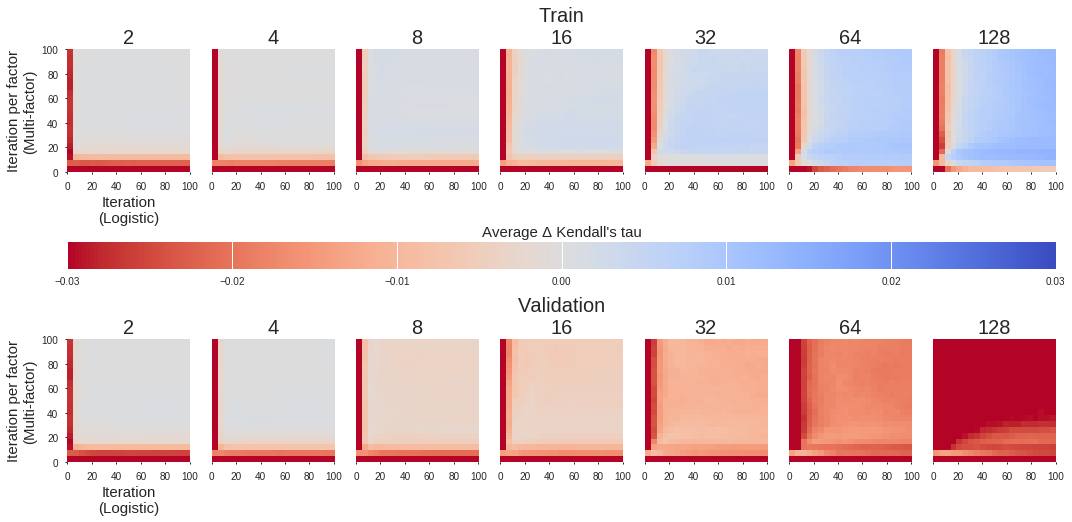

In [70]:
# Plot effects of number of factors, stopping iterations of multi-factor and logistic regression model
# for average Kendall's tau improvement for both train and validation set
fig = plt.figure(figsize=(15, 8))
grid = plt.GridSpec(21, len(n_factors), hspace=0)

for i, (n_factor, taus) in enumerate(avg_dtaus_train_all.items()):
    ax = fig.add_subplot(grid[:10, i])
    ax.set_xticks(range(0, 101, 20))
    ax.set_yticks(range(0, 101, 20))
    ax.imshow(taus.iloc[::-1, :], cmap='coolwarm_r', vmin=-0.3, vmax=0.3, extent=[0, 100, 0, 100])
    ax.grid(None)
    ax.set_title(f'{n_factor}', fontsize=20)
    ax.tick_params(direction='out', length=2)
    if i == 0:
        ax.set_xlabel('Iteration\n(Logistic)', fontsize=15)
        ax.set_ylabel('Iteration per factor\n(Multi-factor)', fontsize=15)        
    else:
        ax.set_yticks([])
        if i == 3:
            ax.set_title(f'Train\n{n_factor}', fontsize=20)
        else:
            ax.set_title(f'{n_factor}', fontsize=20)
        

for i, (n_factor, taus) in enumerate(avg_dtaus_val_all.items()):
    ax = fig.add_subplot(grid[11:, i])
    ax.set_xticks(range(0, 101, 20))
    ax.set_yticks(range(0, 101, 20))
    ax.imshow(taus.iloc[::-1, :], cmap='coolwarm_r', vmin=-0.3, vmax=0.3, extent=[0, 100, 0, 100])
    ax.grid(None)
    ax.set_title(f'{n_factor}', fontsize=20)
    ax.tick_params(direction='out', length=2)
    if i == 0:
        ax.set_xlabel('Iteration\n(Logistic)', fontsize=15)
        ax.set_ylabel('Iteration per factor\n(Multi-factor)', fontsize=15)        
    else:
        ax.set_yticks([])
        if i == 3:
            ax.set_title(f'Validation\n{n_factor}', fontsize=20)
        else:
            ax.set_title(f'{n_factor}', fontsize=20)

axc = fig.add_subplot(grid[10, :])
cmap = plt.cm.get_cmap('coolwarm_r')
colors = cmap(np.arange(cmap.N))
axc.imshow([colors], extent=[-0.03, 0.03, 0, 0.01], aspect='auto')
axc.set_yticks([])
axc.set_title("Average Δ Kendall's tau", fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('viz/3_params_simul_svd.png')

In [71]:
# For each number of factor, get stopping iterations that give the highest average train Kendall's tau improvement
max_train_locations = {}
for n_factor, taus in avg_dtaus_train_all.items():
    taus = avg_dtaus_train_all[n_factor]
    row_idxmax = taus.idxmax(axis=1)
    row_max = taus.max(axis=1)
    tau_max, max_row, max_col = row_max.max(), row_max.idxmax(), row_idxmax[row_max.idxmax()]
    
    max_train_locations[n_factor] = [tau_max, max_row, max_col]
    
max_train_locations

{2: [0.00680030114812723, 50, 70],
 4: [0.008108413325804632, 50, 40],
 8: [0.019779785431959362, 100, 25],
 16: [0.032028985507246366, 25, 70],
 32: [0.06499529456051198, 25, 60],
 64: [0.10190852625635236, 20, 100],
 128: [0.14095238095238097, 15, 90]}

In [72]:
# For each number of factor, get stopping iterations that give the highest average validation Kendall's tau improvement
max_val_locations = {}
for n_factor, taus in avg_dtaus_val_all.items():
    taus = avg_dtaus_val_all[n_factor]
    row_idxmax = taus.idxmax(axis=1)
    row_max = taus.max(axis=1)
    tau_max, max_row, max_col = row_max.max(), row_max.idxmax(), row_idxmax[row_max.idxmax()]
    
    max_val_locations[n_factor] = [tau_max, max_row, max_col]
    
max_val_locations

{2: [0.0058535667231319425, 55, 40],
 4: [0.009410878976096382, 35, 30],
 8: [-0.01733860342555995, 55, 10],
 16: [-0.029508752117447756, 20, 15],
 32: [-0.07564464520986258, 20, 20],
 64: [-0.10764916243177111, 5, 10],
 128: [-0.13488424618859396, 5, 10]}

### Recheck final result

Check if 35 iterations of multi-factor and 30 iterations of logistic for 4 factors give the same average validation Kendall's tau improvement

In [184]:
X1 = {}
X2 = {}
for year in (years1 + years2):
    print(year, end=' ')

    # Step 1: train multi-factor model
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    baselines, event_scores, skater_scores = train_sequential_multi(season_scores, n_factors=4, alpha=0.0005, n_iter=35, verbose=True)

    # Normalize and take pairwise differences
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))

    # Store difference matrices for each year
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X

# Stack predictor matrices for both folds
stacked_X1 = np.concatenate(list(X1.values()))
stacked_X2 = np.concatenate(list(X2.values()))

# Step 2: train logistic regression model for both folds
# Remember to add 1 to the optimum result since iter 30 is really the 31st iteration
print('1st fold')
beta1 = log_gradient_ascent(stacked_X1, n_iter=31, alpha=0.0005)
print('2nd fold')
beta2 = log_gradient_ascent(stacked_X2, n_iter=31, alpha=0.0005)

2016 Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 10.983, Delta RMSE: -0.0010950823
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 10.923, Delta RMSE: -0.0038132545
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 10.859, Delta RMSE: -0.0031820011
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 10.778, Delta RMSE: -0.0057964043
2006 Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 7.999, Delta RMSE: -0.007749829
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 7.986, Delta RMSE: -0.0006821397
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 7.957, Delta RMSE: -0.0011246966
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 7.931, Delta RMSE: -0.0010131301
2012 Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 8.382, Delta RMSE: -0.0155885481
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 8.353, Delta RMSE: -0.0009052541
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 8.323, Delta RMSE: -0.0013255725
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 8.305, Delta RMSE: -0.0006082238
2005 Factor: 0, Alpha:

In [185]:
X_full = np.vstack([stacked_X1, stacked_X2])
beta_full = log_gradient_ascent(X_full, n_iter=31, alpha=0.0005)

Alpha: 0.0005, Iter: 30, Last LL: -0.36, Delta LL: 1.43165e-05


In [186]:
dtaus_train = {}
dtaus_val = {}
for year in years1:
    dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
    dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
for year in years2:
    dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
    dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]

In [187]:
np.mean(list(dtaus_train.values())), np.std(list(dtaus_train.values()))

(0.002697157914549231, 0.04835962001684241)

In [188]:
dtaus_val_mean, dtaus_val_std = np.mean(list(dtaus_val.values())), np.std(list(dtaus_val.values()))

In [189]:
# Show mean and CI for validation improvement in Kendall's tau
dtaus_val_mean, dtaus_val_mean - ci_multiplier * dtaus_val_std, dtaus_val_mean + ci_multiplier * dtaus_val_std

(0.009410878976096382, -0.023130362569420394, 0.04195212052161316)

Store beta

In [190]:
np.save('data/male_beta1.npy', beta1)
np.save('data/male_beta2.npy', beta2)
np.save('data/male_betafull.npy', beta_full)

### Visualization for 2017

In [146]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
baseline, event_scores, skater_scores = train_sequential_multi(season_scores,
alpha=0.0005, n_iter=35, n_factors=4)

Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 8.871, Delta RMSE: -0.0020925243
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 8.861, Delta RMSE: -0.0004265281
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 8.836, Delta RMSE: -0.0016416719
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 8.784, Delta RMSE: -0.0022976621


In [136]:
# Generate predictor model
skater_scores = skater_scores.reindex(world_scores.index).dropna()
normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))
print(X.shape)
X

(276, 4)


array([[ 0.49163923, -0.67165654,  0.85232186, -2.22569311],
       [ 1.24076026, -1.32925196,  0.63709627, -0.83599161],
       [ 0.52035915, -2.73334605, -1.76776076, -1.75283656],
       ...,
       [ 0.02171402, -1.07927407,  1.3286254 ,  1.02097179],
       [-0.38432837, -0.38019588,  1.66580707,  1.86021274],
       [-0.40604239,  0.69907818,  0.33718167,  0.83924096]])

In [148]:
normed_skater_scores

,0,1,2,3
name,,,,
"Yuzuru, HANYU",1.995237,-1.131016,-0.348607,-1.552463
"Shoma, UNO",1.503598,-0.459359,-1.200929,0.673230
"Boyang, JIN",0.754477,0.198236,-0.985703,-0.716471
"Javier, FERNANDEZ",1.474878,1.602330,1.419154,0.200374
"Patrick, CHAN",1.161475,-0.417528,1.476293,1.542986
"Nathan, CHEN",1.575989,-0.918469,0.864877,-1.100298
"Jason, BROWN",0.220183,-0.195797,0.394531,-0.022904
"Mikhail, KOLYADA",-0.072878,0.544807,0.777407,0.118641
"Kevin, REYNOLDS",-0.151242,0.224231,0.469069,0.629897


In [141]:
# Since 2017 belongs to 2nd fold, use beta from the 1st fold to evaluate it
y_pred = (X @ beta1) > 0
y_pred.sum()

242

In [138]:
# Get all normalized skater latent scores along with combined scores
result_scores = pd.DataFrame(normed_skater_scores, index=world_ranking)
result_scores['Combined'] = normed_skater_scores @ beta1
result_scores.head()

,0,1,2,3,Combined
"Yuzuru, HANYU",1.995237,-1.131016,-0.348607,-1.552463,3.420402
"Shoma, UNO",1.503598,-0.459359,-1.200929,0.673230,2.775205
"Boyang, JIN",0.754477,0.198236,-0.985703,-0.716471,1.186455
"Javier, FERNANDEZ",1.474878,1.602330,1.419154,0.200374,2.737167
"Patrick, CHAN",1.161475,-0.417528,1.476293,1.542986,2.467298


In [122]:
# Rank skaters by each individual score
result_ranks = result_scores.values.argsort(axis=0).argsort(axis=0)
pd.DataFrame(result_ranks, index=world_ranking).head()

,0,1,2,3
"Yuzuru, HANYU",23,3,10,0
"Shoma, UNO",21,8,1,17
"Boyang, JIN",17,13,6,8
"Javier, FERNANDEZ",20,22,21,13
"Patrick, CHAN",19,9,22,21


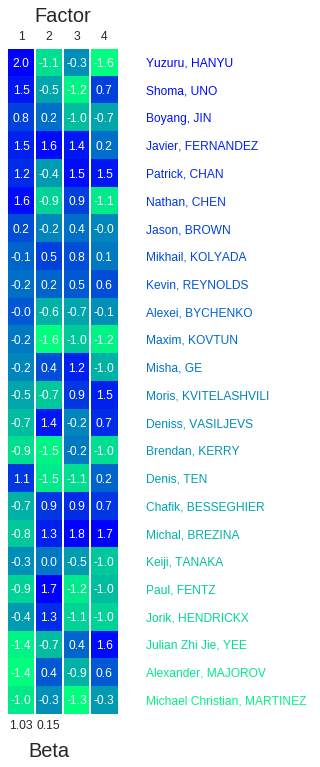

In [123]:
# Plot scores and rankings from each latent factor, along with combined scores
winter_cmap = mpl.cm.get_cmap('winter')

fig = plt.figure(figsize=(6, 11))
grid = plt.GridSpec(1, 2, wspace=0, bottom=0.08, top=0.92)
ax = fig.add_subplot(grid[:, 0])
ax1 = fig.add_subplot(grid[:, 1], sharey=ax)

n_skaters = result_scores.shape[0]
n_scores = result_scores.shape[1]

ax.imshow(result_ranks, cmap='winter_r')
ax.grid(None)

for i in range(n_skaters):
    ax1.text(0, i, f'{world_ranking[i]}', ha='left', va='center', color=winter_cmap(i/n_skaters), fontsize=12)
    for j in range(n_scores):
        ax.text(j, i, f'{result_scores.iloc[i, j]:.1f}', ha='center', va='center', color='w', fontsize=12)
        
for i in range(n_scores):
    ax.axvline(i-0.5, lw=2, color='w')
    
ax.set_yticks([])
ax.set_xticks(range(result_scores.shape[1]))
ax.set_xticklabels(['1', '2', '3', '4', 'Comb.'], fontsize=12)

ax.xaxis.tick_top()
ax.yaxis.tick_right()

for i, b in enumerate(beta1):
    ax.text(i, n_skaters, f'{b:.2f}', ha='center', fontsize=12)
ax.text(n_scores/2-1, n_skaters+1, 'Beta', ha='center', fontsize=20)   
ax.text(n_scores/2-0.5, -1.5, 'Factor', ha='center', fontsize=20)  

ax1.set_facecolor('w')
ax1.set_xticks([])

fig.savefig('viz/5_factors_seq.png')

Compare predicted ranking of 1st and combined scores

In [142]:
calculate_kendall_tau(list(result_scores[0].sort_values(ascending=False).index), world_ranking)

There are 241 concordant_pairs out of 276 pairs


0.7463768115942029

In [143]:
calculate_kendall_tau(list(result_scores['Combined'].sort_values(ascending=False).index), world_ranking)

There are 242 concordant_pairs out of 276 pairs


0.7536231884057971

In [144]:
result_scores

,0,1,2,3,Combined
"Yuzuru, HANYU",1.995237,-1.131016,-0.348607,-1.552463,3.420402
"Shoma, UNO",1.503598,-0.459359,-1.200929,0.673230,2.775205
"Boyang, JIN",0.754477,0.198236,-0.985703,-0.716471,1.186455
"Javier, FERNANDEZ",1.474878,1.602330,1.419154,0.200374,2.737167
"Patrick, CHAN",1.161475,-0.417528,1.476293,1.542986,2.467298
"Nathan, CHEN",1.575989,-0.918469,0.864877,-1.100298,2.800364
"Jason, BROWN",0.220183,-0.195797,0.394531,-0.022904,0.433013
"Mikhail, KOLYADA",-0.072878,0.544807,0.777407,0.118641,-0.085931
"Kevin, REYNOLDS",-0.151242,0.224231,0.469069,0.629897,-0.157336
"Alexei, BYCHENKO",-0.046560,-0.604709,-0.653029,-0.062675,-0.111496


# Do the same for female skaters

In [86]:
fall_season_scores = female_scores.loc[female_scores['event']!='WR']
fall_world_scores = female_scores.loc[female_scores['event']=='WR']

In [87]:
# Get yearly Kendall's tau from average model for comparison
favg = AverageScore()
favg_result = favg.evaluate_over_years(all_years, fall_season_scores, fall_world_scores).set_index('year')
favg_taus = favg_result['tau'].to_dict()

In [88]:
def cross_val_by_factor_seq(n_factors, years1, years2, season_scores_df, world_scores_df, avg_taus,
                            multi_n_iter, log_n_iter,
                            multi_alpha=0.0005, log_alpha=0.0005,
                            log_multi_every=20, log_log_every=20):
    X1 = {}
    X2 = {}

    avg_dtaus_train = {}
    avg_dtaus_val = {}

    for multi_iter in np.arange(0, multi_n_iter, log_multi_every):
        print(f'{n_factors} factors, {multi_iter} iters')
        for year in (years1 + years2):

            # Step 1: train multi-factor model
            season_scores, world_scores = get_yearly_scores(year, season_scores_df, world_scores_df)
            _, _, skater_scores = train_sequential_multi(season_scores, n_factors=n_factors, alpha=multi_alpha, n_iter=multi_iter, verbose=False)

            # Normalize and take pairwise differences
            skater_scores = skater_scores.reindex(world_scores.index).dropna()
            normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
            X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))

            # Store difference matrices for each year
            if year in years1:
                X1[year] = X
            else:
                X2[year] = X

        # Stack predictor matrices for both folds
        stacked_X1 = np.concatenate(list(X1.values()))
        stacked_X2 = np.concatenate(list(X2.values()))
        
        # Create logistic regression model generators for each fold
        log_gen1 = log_gradient_ascent_log(stacked_X1, alpha=log_alpha, n_iter=log_n_iter, log_every=log_log_every, verbose=False)
        log_gen2 = log_gradient_ascent_log(stacked_X2, alpha=log_alpha, n_iter=log_n_iter, log_every=log_log_every, verbose=False)

        # Train logistic regression model on each fold and return logged values at specified iterations
        for log_log1, log_log2 in zip(log_gen1, log_gen2):
            log_iter = log_log1[0]
            beta1 = log_log1[1]
            beta2 = log_log2[1]

            # Model coefficients at specified iterations are used to evaluate
            # improvement in Kendall's tau on both folds
            dtaus_train = {}
            dtaus_val = {}
            for year in years1:
                dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
                dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
            for year in years2:
                dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
                dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]

            # Take average improvement in Kendall's tau for each combination of
            # stopping iterations of multi-factor and logistic regression model
            avg_dtaus_train[(multi_iter, log_iter)] = np.mean(list(dtaus_train.values()))
            avg_dtaus_val[(multi_iter, log_iter)] = np.mean(list(dtaus_val.values()))
    return pd.Series(avg_dtaus_train).unstack(), pd.Series(avg_dtaus_val).unstack()

In [89]:
# Perform 2-fold cross validation for each factors (2,4,8,...,128)
n_factors = 2**np.arange(1, 8)
favg_dtaus_train_all = {}
favg_dtaus_val_all = {}

for n_factor in n_factors:
    print(f'{n_factor} factors')
    favg_dtaus_train, favg_dtaus_val = cross_val_by_factor_seq(n_factor, years1, years2, fall_season_scores, fall_world_scores, favg_taus,
                                    multi_n_iter=101, log_n_iter=101,
                                    log_multi_every=5, log_log_every=5)
    favg_dtaus_train_all[n_factor] = favg_dtaus_train
    favg_dtaus_val_all[n_factor] = favg_dtaus_val

2 factors
2 factors, 0 iters
2 factors, 5 iters
2 factors, 10 iters
2 factors, 15 iters
2 factors, 20 iters
2 factors, 25 iters
2 factors, 30 iters
2 factors, 35 iters
2 factors, 40 iters
2 factors, 45 iters
2 factors, 50 iters
2 factors, 55 iters
2 factors, 60 iters
2 factors, 65 iters
2 factors, 70 iters
2 factors, 75 iters
2 factors, 80 iters
2 factors, 85 iters
2 factors, 90 iters
2 factors, 95 iters
2 factors, 100 iters
4 factors
4 factors, 0 iters
4 factors, 5 iters
4 factors, 10 iters
4 factors, 15 iters
4 factors, 20 iters
4 factors, 25 iters
4 factors, 30 iters
4 factors, 35 iters
4 factors, 40 iters
4 factors, 45 iters
4 factors, 50 iters
4 factors, 55 iters
4 factors, 60 iters
4 factors, 65 iters
4 factors, 70 iters
4 factors, 75 iters
4 factors, 80 iters
4 factors, 85 iters
4 factors, 90 iters
4 factors, 95 iters
4 factors, 100 iters
8 factors
8 factors, 0 iters
8 factors, 5 iters
8 factors, 10 iters
8 factors, 15 iters
8 factors, 20 iters
8 factors, 25 iters
8 factors, 30 

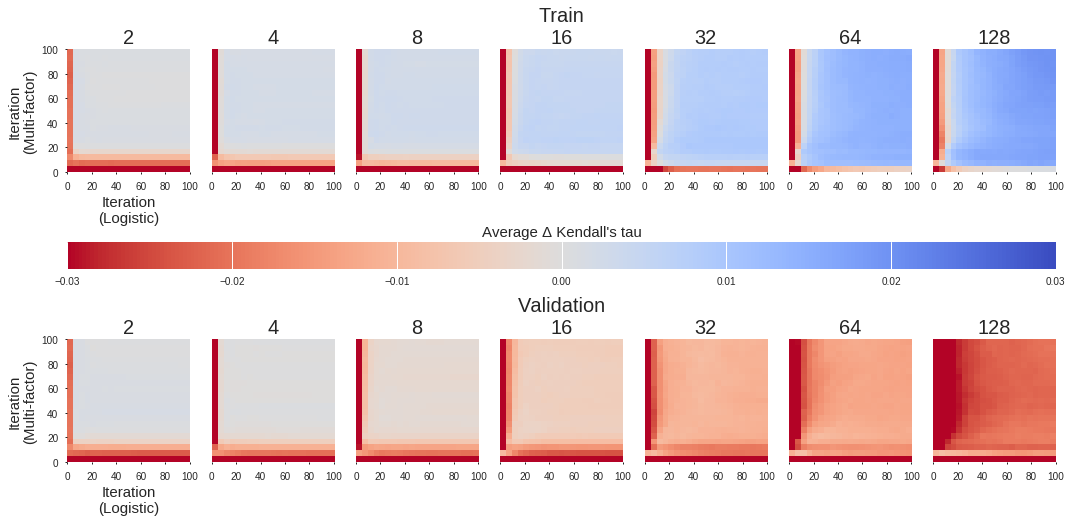

In [90]:
# Plot effects of number of factors, stopping iterations of multi-factor and logistic regression model
# for average Kendall's tau improvement for both train and validation set
fig = plt.figure(figsize=(15, 8))
grid = plt.GridSpec(21, len(n_factors), hspace=0)

for i, (n_factor, taus) in enumerate(favg_dtaus_train_all.items()):
    ax = fig.add_subplot(grid[:10, i])
    ax.set_xticks(range(0, 101, 20))
    ax.set_yticks(range(0, 101, 20))
    ax.imshow(taus.iloc[::-1, :], cmap='coolwarm_r', vmin=-0.3, vmax=0.3, extent=[0, 100, 0, 100])
    ax.grid(None)
    ax.set_title(f'{n_factor}', fontsize=20)
    ax.tick_params(direction='out', length=2)
    if i == 0:
        ax.set_xlabel('Iteration\n(Logistic)', fontsize=15)
        ax.set_ylabel('Iteration\n(Multi-factor)', fontsize=15)        
    else:
        ax.set_yticks([])
        if i == 3:
            ax.set_title(f'Train\n{n_factor}', fontsize=20)
        else:
            ax.set_title(f'{n_factor}', fontsize=20)
        

for i, (n_factor, taus) in enumerate(favg_dtaus_val_all.items()):
    ax = fig.add_subplot(grid[11:, i])
    ax.set_xticks(range(0, 101, 20))
    ax.set_yticks(range(0, 101, 20))
    ax.imshow(taus.iloc[::-1, :], cmap='coolwarm_r', vmin=-0.3, vmax=0.3, extent=[0, 100, 0, 100])
    ax.grid(None)
    ax.set_title(f'{n_factor}', fontsize=20)
    ax.tick_params(direction='out', length=2)
    if i == 0:
        ax.set_xlabel('Iteration\n(Logistic)', fontsize=15)
        ax.set_ylabel('Iteration\n(Multi-factor)', fontsize=15)        
    else:
        ax.set_yticks([])
        if i == 3:
            ax.set_title(f'Validation\n{n_factor}', fontsize=20)
        else:
            ax.set_title(f'{n_factor}', fontsize=20)

axc = fig.add_subplot(grid[10, :])
cmap = plt.cm.get_cmap('coolwarm_r')
colors = cmap(np.arange(cmap.N))
axc.imshow([colors], extent=[-0.03, 0.03, 0, 0.01], aspect='auto')
axc.set_yticks([])
axc.set_title("Average Δ Kendall's tau", fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('viz/female_3_params_simul_svd.png')

In [94]:
# For each number of factor, get stopping iterations that give the highest average train Kendall's tau improvement
max_train_locations = {}
for n_factor, taus in favg_dtaus_train_all.items():
    taus = favg_dtaus_train_all[n_factor]
    row_idxmax = taus.idxmax(axis=1)
    row_max = taus.max(axis=1)
    tau_max, max_row, max_col = row_max.max(), row_max.idxmax(), row_idxmax[row_max.idxmax()]
    
    max_train_locations[n_factor] = [tau_max, max_row, max_col]
    
max_train_locations

{2: [0.0184490871447393, 70, 5],
 4: [0.025369847543760583, 50, 15],
 8: [0.034270656879352504, 30, 15],
 16: [0.06283079239600978, 25, 65],
 32: [0.09561076604554863, 25, 55],
 64: [0.15709956709956707, 95, 100],
 128: [0.19904385469602856, 100, 100]}

In [95]:
# For each number of factor, get stopping iterations that give the highest average validation Kendall's tau improvement
max_val_locations = {}
for n_factor, taus in favg_dtaus_val_all.items():
    taus = favg_dtaus_val_all[n_factor]
    row_idxmax = taus.idxmax(axis=1)
    row_max = taus.max(axis=1)
    tau_max, max_row, max_col = row_max.max(), row_max.idxmax(), row_idxmax[row_max.idxmax()]
    
    max_val_locations[n_factor] = [tau_max, max_row, max_col]
    
max_val_locations

{2: [0.014899303594955754, 65, 5],
 4: [0.006054959533220383, 40, 20],
 8: [-0.010796160361377783, 35, 20],
 16: [-0.033231695840391505, 25, 25],
 32: [-0.08816676077545646, 85, 45],
 64: [-0.08026538678712594, 5, 5],
 128: [-0.08624505928853757, 5, 5]}

### Recheck final result

Check if 65 iterations of multi-factor and 5 iterations of logistic for 2 factors give the same average validation Kendall's tau improvement

In [110]:
X1 = {}
X2 = {}
for year in (years1 + years2):
    print(year, end=' ')

    # Step 1: train multi-factor model
    season_scores, world_scores = get_yearly_scores(year, fall_season_scores, fall_world_scores)
    baselines, event_scores, skater_scores = train_sequential_multi(season_scores, n_factors=2, alpha=0.0005, n_iter=65, verbose=True)

    # Normalize and take pairwise differences
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))

    # Store difference matrices for each year
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X

# Stack predictor matrices for both folds
stacked_X1 = np.concatenate(list(X1.values()))
stacked_X2 = np.concatenate(list(X2.values()))

# Step 2: train logistic regression model for both folds
# Remember to add 1 to the ideal iterations for logistic since Iter: 5 means there are 6 iterations
print('1st fold')
beta1 = log_gradient_ascent(stacked_X1, n_iter=6, alpha=0.0005)
print('2nd fold')
beta2 = log_gradient_ascent(stacked_X2, n_iter=6, alpha=0.0005)

2016 Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.246, Delta RMSE: -0.0004891715
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.168, Delta RMSE: -0.0023272443
2006 Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.646, Delta RMSE: -0.0012421858
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.528, Delta RMSE: -0.0046370313
2012 Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 5.585, Delta RMSE: -0.0004434968
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 5.573, Delta RMSE: -0.0002517499
2005 Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.3, Delta RMSE: -0.0009581742
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.269, Delta RMSE: -0.0009046723
2014 Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.257, Delta RMSE: -0.0002564663
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.201, Delta RMSE: -0.0015202997
2007 Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.39, Delta RMSE: -0.0009371606
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.383, Delta RMSE: -0.0001996698
2009 Factor: 

In [191]:
for year in (years1 + years2):

    # Step 1: train multi-factor model
    season_scores, world_scores = get_yearly_scores(year, fall_season_scores, fall_world_scores)
    _, _, skater_scores = train_sequential_multi(season_scores, n_factors=2, alpha=0.0005, n_iter=65, verbose=False)

    # Normalize and take pairwise differences
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))

    # Store difference matrices for each year
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X

# Stack predictor matrices for both folds
stacked_X1 = np.concatenate(list(X1.values()))
stacked_X2 = np.concatenate(list(X2.values()))
X_full = np.vstack([stacked_X1, stacked_X2])

# Create logistic regression model generators for each fold
beta1 = log_gradient_ascent(stacked_X1, alpha=0.0005, n_iter=6, verbose=False)
beta2 = log_gradient_ascent(stacked_X2, alpha=0.0005, n_iter=6, verbose=False)
beta_full = log_gradient_ascent(X_full, alpha=0.0005, n_iter=6, verbose=False)

In [192]:
dtaus_train = {}
dtaus_val = {}
for year in years1:
    dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - favg_taus[year]
    dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - favg_taus[year]
for year in years2:
    dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - favg_taus[year]
    dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - favg_taus[year]

Get mean and standard deviation of validation Kendall's tau improvement

In [193]:
np.mean(list(dtaus_train.values())), np.std(list(dtaus_train.values()))

(0.016134010916619597, 0.036135802654926226)

In [194]:
dtaus_val_mean, dtaus_val_std = np.mean(list(dtaus_val.values())), np.std(list(dtaus_val.values()))
dtaus_val_mean, dtaus_val_std

(0.014899303594955754, 0.04015355532927654)

In [195]:
dtaus_val_mean, dtaus_val_mean - ci_multiplier * dtaus_val_std, dtaus_val_mean + ci_multiplier * dtaus_val_std

(0.014899303594955754, -0.01382282390791106, 0.04362143109782257)

Store betas

In [196]:
np.save('data/female_beta1.npy', beta1)
np.save('data/female_beta2.npy', beta2)
np.save('data/female_betafull.npy', beta_full)